# Reddit Sentiment Analysis for Tech Stock Prediction

This script performs sentiment analysis on Reddit comments for major tech companies and correlates it with their stock prices.

## Cell 0: Import Libraries and Set Up Environment

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch
import yfinance as yf
from datetime import datetime, timedelta

: 

## Cell 1: Clean Data and Sort by Company Mentioned

In [70]:
# Load the dataset
df = pd.read_csv('data/tech_threads_last_year.csv')


# Define a list of companies
companies = ['Apple', 'Google', 'Microsoft', 'Amazon', 'Facebook']

# Define a function to clean up and filter the text
def clean_text(text):
    if isinstance(text, str):
        cutoff_points = ["<N", "*****", "CLICK HERE", "&amp;", "&gt;", "source:", "chart"]
        for point in cutoff_points:
            if point in text:
                text = text.split(point)[0].strip()
        return text
    return text

# Apply the text cleaning function to the 'text' column
df['text'] = df['text'].apply(clean_text)

# Function to find which company is in the title
def find_company(title):
    if isinstance(title, str):  # Check if title is a string
        for company in companies:
            if company.lower() in title.lower():  # Check if any company name is in the title (case-insensitive)
                return company
    return 'Other'  # If no company is found, or if title is not a string, label it as 'Other'

# Apply the find_company function to the 'title' column and create a new 'company' column
df['company'] = df['title'].apply(find_company)

# Sort the DataFrame by the 'company' column
df_sorted = df.sort_values(by='company')

# Optionally, filter out rows where the 'text' is now empty after cleaning
df_cleaned_sorted = df_sorted[df_sorted['text'].str.strip() != ""]

# Save the cleaned and sorted dataset to a new CSV file
df_cleaned_sorted.to_csv('data/cleaned_sorted_reddit_data_year.csv', index=False)

print("Cleaning and sorting complete. The dataset has been saved to 'cleaned_sorted_reddit_data_year.csv'.")


Cleaning and sorting complete. The dataset has been saved to 'cleaned_sorted_reddit_data_year.csv'.


## Cell 2: Clean Data and Sort by Company Mentioned

In [71]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from transformers import pipeline
import datetime as dt

# Sentiment analysis using Hugging Face's transformer pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Define a list of companies and their ticker symbols
companies = {
    'Apple': 'AAPL',
    'Google': 'GOOGL',
    'Microsoft': 'MSFT',
    'Amazon': 'AMZN',
    'Facebook': 'META'
}

# Load Reddit data (replace 'cleaned_sorted_reddit_data_year.csv' with your actual file)
df = pd.read_csv('data/cleaned_sorted_reddit_data_year.csv')

# Perform sentiment analysis on each comment
def analyze_sentiment(text):
    if isinstance(text, str) and text.strip():
        result = sentiment_pipeline(text[:512])  # Process first 512 characters (limits for some models)
        return result[0]['label'], result[0]['score']
    return 'Neutral', 0.0

# Apply sentiment analysis to the 'text' column (the Reddit comments)
df['sentiment'], df['sentiment_score'] = zip(*df['text'].apply(analyze_sentiment))

# Save the sentiment analysis results to a new CSV
df.to_csv('data/reddit_comments_with_sentiment.csv', index=False)

print("Sentiment analysis complete. Files saved.")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/home/dalton/Desktop/Portfolio/SentimentsForStocks/general/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Sentiment analysis complete. Files saved.


## Cell 3: Define Helper Functions

In [72]:
# Fetch stock data for a given ticker and date range
# Return a dataframe with Date and Close price
def fetch_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    return df[['Date', 'Close']]

# Calculate returns, moving averages, and exponential moving average
# Return the dataframe with additional features
def create_stock_features(stock_df):
    stock_df['Returns'] = stock_df['Close'].pct_change()
    stock_df['MA7'] = stock_df['Close'].rolling(window=7).mean()
    stock_df['MA21'] = stock_df['Close'].rolling(window=21).mean()
    stock_df['EMA'] = stock_df['Close'].ewm(span=21, adjust=False).mean()
    return stock_df

# Plot a circle representing sentiment on the stock chart
# Circle size and color depend on sentiment strength and direction
def plot_sentiment_circle(ax, date, close_price, sentiment_sum, markers_set):
    size = abs(sentiment_sum) * 20 + 50  # Base size of 50, increasing by 20 for each sentiment
    if sentiment_sum > 0:
        color = 'limegreen'
        markers_set.add('positive')
    elif sentiment_sum < 0:
        color = 'tomato'
        markers_set.add('negative')
    else:
        return  # Don't plot if sentiment_sum is 0

    circle = ax.scatter(date, close_price, s=size, c=color, alpha=0.7, zorder=5, edgecolors='grey')
    
    # Calculate font size based on circle size
    font_size = np.sqrt(size) * 0.5
    
    ax.annotate(str(sentiment_sum), (date, close_price), xytext=(0, 0), 
                textcoords="offset points", ha='center', va='center', 
                fontweight='bold', fontsize=font_size, color='black')

    return circle

# Plot arrows representing sentiment direction and strength
def plot_sentiment_arrows(ax, date, close_price, sentiment_sum, max_sentiment, scale=0.05):
    if sentiment_sum == 0:
        return
    
    dx = 2  # Arrow points 2 days to the right
    normalized_sentiment = sentiment_sum / max_sentiment if max_sentiment != 0 else 0
    dy = normalized_sentiment * scale * close_price  # Scale arrow height based on stock price and normalized sentiment
    arrow_color = 'limegreen' if sentiment_sum > 0 else 'red'
    ax.arrow(date, close_price, dx, dy, 
             head_width=1, head_length=0.8,
             fc=arrow_color, ec=arrow_color,
             alpha=0.8,
             linewidth=1.5,
             length_includes_head=True,
             zorder=10)
    
# Create a comprehensive plot showing stock price and sentiment indicators
def plot_stock_with_sentiments(data, company_name, start_date, end_date):
    plt.style.use('Solarize_Light2')
    fig, ax = plt.subplots(figsize=(14, 7))

    ax.plot(data['Date'], data['Close'], label='Close Price', color='grey', lw=2.5, alpha=0.9, zorder=3)

    markers_set = set()
    grouped_data = data.groupby('Date')
    for date, group in grouped_data:
        close_price = group['Close'].mean()
        sentiment_sum = group['net_sentiment'].sum()
        plot_sentiment_circle(ax, date, close_price, sentiment_sum, markers_set)
        plot_sentiment_arrows(ax, date, close_price, sentiment_sum, data['net_sentiment'].abs().max())

    legend_elements = [Line2D([0], [0], color='black', lw=2.5, label='Close Price')]
    if 'positive' in markers_set:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Positive Sentiment',
                                      markerfacecolor='limegreen', markersize=12, alpha=0.7, markeredgecolor='black'))
    if 'negative' in markers_set:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Negative Sentiment',
                                      markerfacecolor='tomato', markersize=12, alpha=0.7, markeredgecolor='black'))

    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=12)
    plt.subplots_adjust(bottom=0.25, left=0.1, right=0.95, top=0.85)

    ax.grid(True, which='major', axis='both', linestyle='-', linewidth=0.6, alpha=0.7)
    ax.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.3, alpha=0.5)

    ax.set_title(f'{company_name} Stock Price with Reddit Sentiment Indicators', fontsize=20, fontweight='bold', color='darkblue', pad=20)
    ax.set_xlabel('Date', fontsize=15, labelpad=15)
    ax.set_ylabel('Stock Close Price', fontsize=15, labelpad=15)

    ax.legend(handles=legend_elements, loc='best', fontsize=12, frameon=True, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.show()

# Create a multi-panel figure showing stock prices and sentiments for all companies
def plot_comprehensive_figure(companies, start_date, end_date, sentiment_df):
    plt.style.use('Solarize_Light2')
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(3, 2, figure=fig)
    
    for idx, (company, ticker) in enumerate(companies.items()):
        ax = fig.add_subplot(gs[idx // 2, idx % 2])
        
        # Fetch stock data
        stock_data = fetch_stock_data(ticker, start_date, end_date)
        stock_data = create_stock_features(stock_data)
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        
        # Filter sentiment data for the current company
        company_sentiment = sentiment_df[sentiment_df['company'] == company].copy()
        company_sentiment['date_utc'] = pd.to_datetime(company_sentiment['date_utc'])
        
        # Group sentiment data by week and calculate sum of sentiments
        company_sentiment['Week'] = company_sentiment['date_utc'].dt.to_period('W')
        weekly_sentiment = company_sentiment.groupby('Week')['net_sentiment'].sum().reset_index()
        weekly_sentiment['Week'] = weekly_sentiment['Week'].dt.start_time
        
        # Calculate the maximum absolute sentiment for scaling
        max_sentiment = weekly_sentiment['net_sentiment'].abs().max()
        
        # Merge stock data with weekly sentiment data
        merged_df = pd.merge(stock_data, weekly_sentiment, left_on='Date', right_on='Week', how='left')
        merged_df['net_sentiment'] = merged_df['net_sentiment'].fillna(0)
        
        # Plot stock price
        ax.plot(merged_df['Date'], merged_df['Close'], label='Close Price', color='black', lw=2, alpha=0.7)
        
        # Plot weekly average line with dotted style
        merged_df['WeekStart'] = merged_df['Date'].dt.to_period('W').dt.start_time
        weekly_avg = merged_df.groupby('WeekStart')['Close'].mean().reset_index()
        ax.plot(weekly_avg['WeekStart'], weekly_avg['Close'], color='darkgrey', lw=2, 
                linestyle=':', label='Weekly Average')
        
        # Plot sentiment arrows
        for _, row in merged_df.iterrows():
            if row['net_sentiment'] != 0:
                plot_sentiment_arrows(ax, row['Date'], row['Close'], row['net_sentiment'], max_sentiment)
        
        ax.set_title(f'{company} ({ticker})', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Stock Price', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Format x-axis
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        ax.legend(loc='upper left', fontsize=10)
    
    plt.tight_layout()
    fig.suptitle('Stock Prices and Reddit Sentiment for Major Tech Companies', 
                 fontsize=24, fontweight='bold', y=1.02)
    
    # Add a common legend for sentiment arrows with matching colors
    legend_elements = [
        FancyArrowPatch((0, 0), (1, 1), color='limegreen', 
                        mutation_scale=20, lw=2, arrowstyle='-|>', label='Positive Sentiment'),
        FancyArrowPatch((0, 0), (1, -1), color='red', 
                        mutation_scale=20, lw=2, arrowstyle='-|>', label='Negative Sentiment')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize=12)
    
    plt.show()


## Cell 4: Load and Preprocess Reddit Data

In [73]:
# Define companies and date range
companies = {
    'Apple': 'AAPL',
    'Google': 'GOOGL',
    'Microsoft': 'MSFT',
    'Amazon': 'AMZN'
}

end_date = datetime(2024, 9, 17)  # Current date in the script
start_date = end_date - timedelta(days=365)  # One year ago

# Load the Reddit sentiment data
df = pd.read_csv('data/reddit_comments_with_sentiment.csv')

# Ensure the sentiment DataFrame has the correct data types
df['net_sentiment'] = df['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1, 'NEUTRAL': 0})
df['date_utc'] = pd.to_datetime(df['date_utc']).dt.date  # Convert to date, not datetime


## Cell 5: Define Companies and Date Range

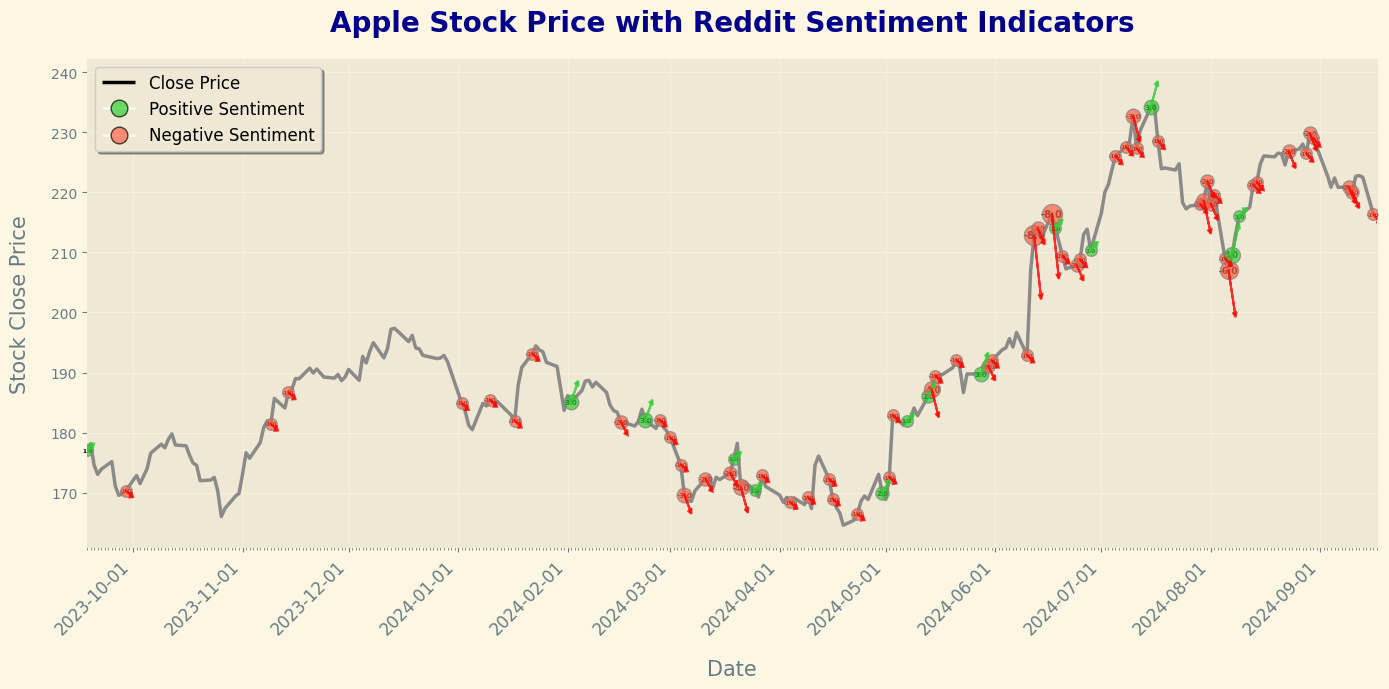

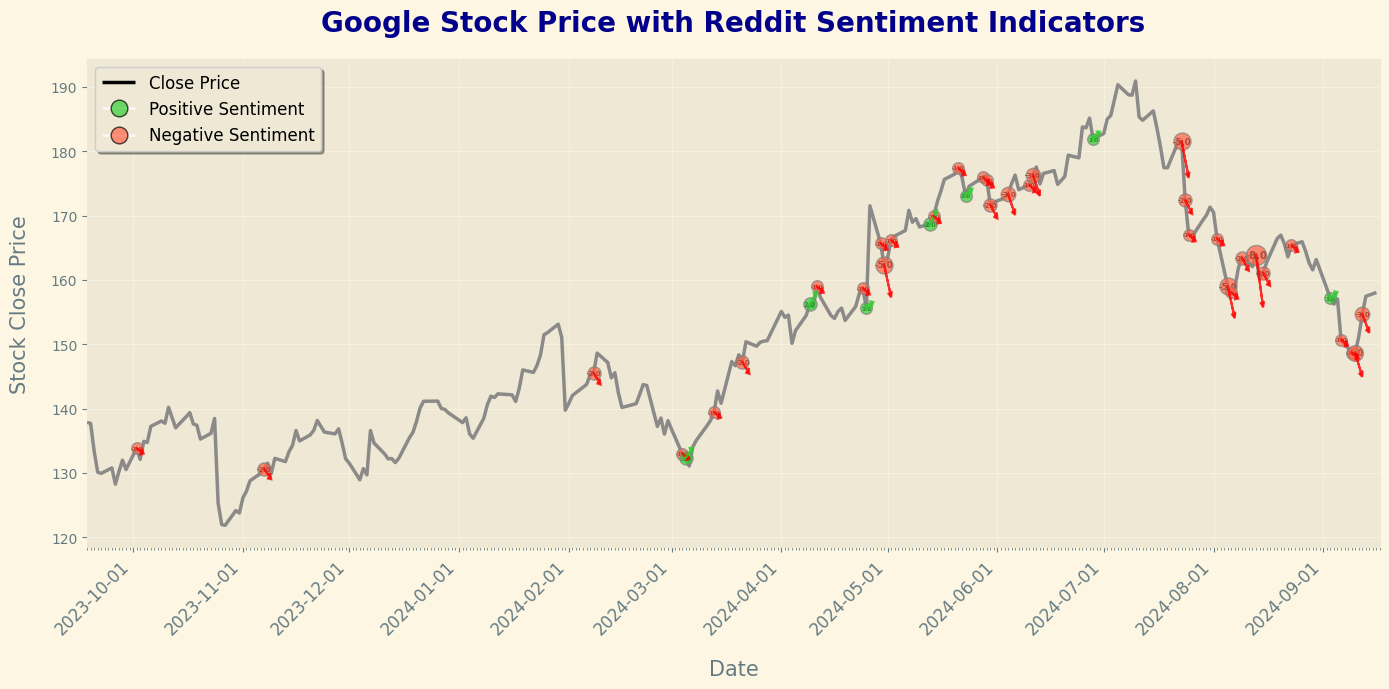

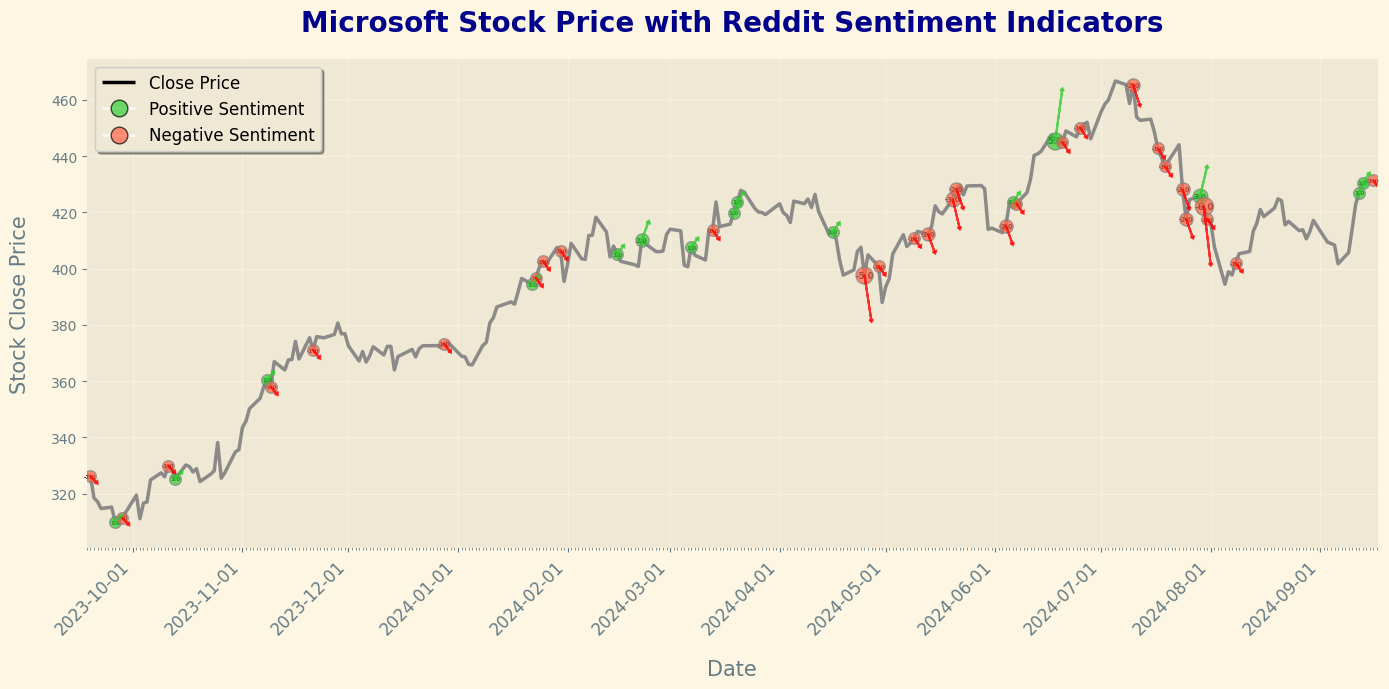

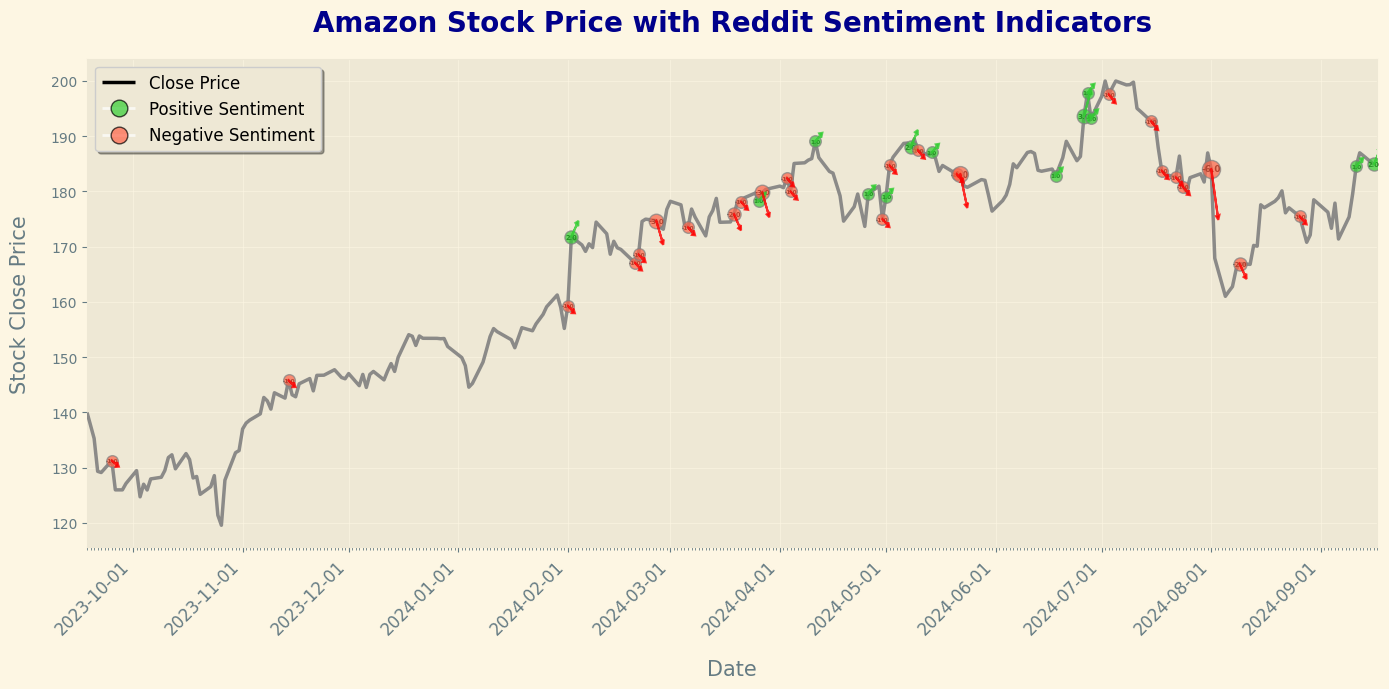

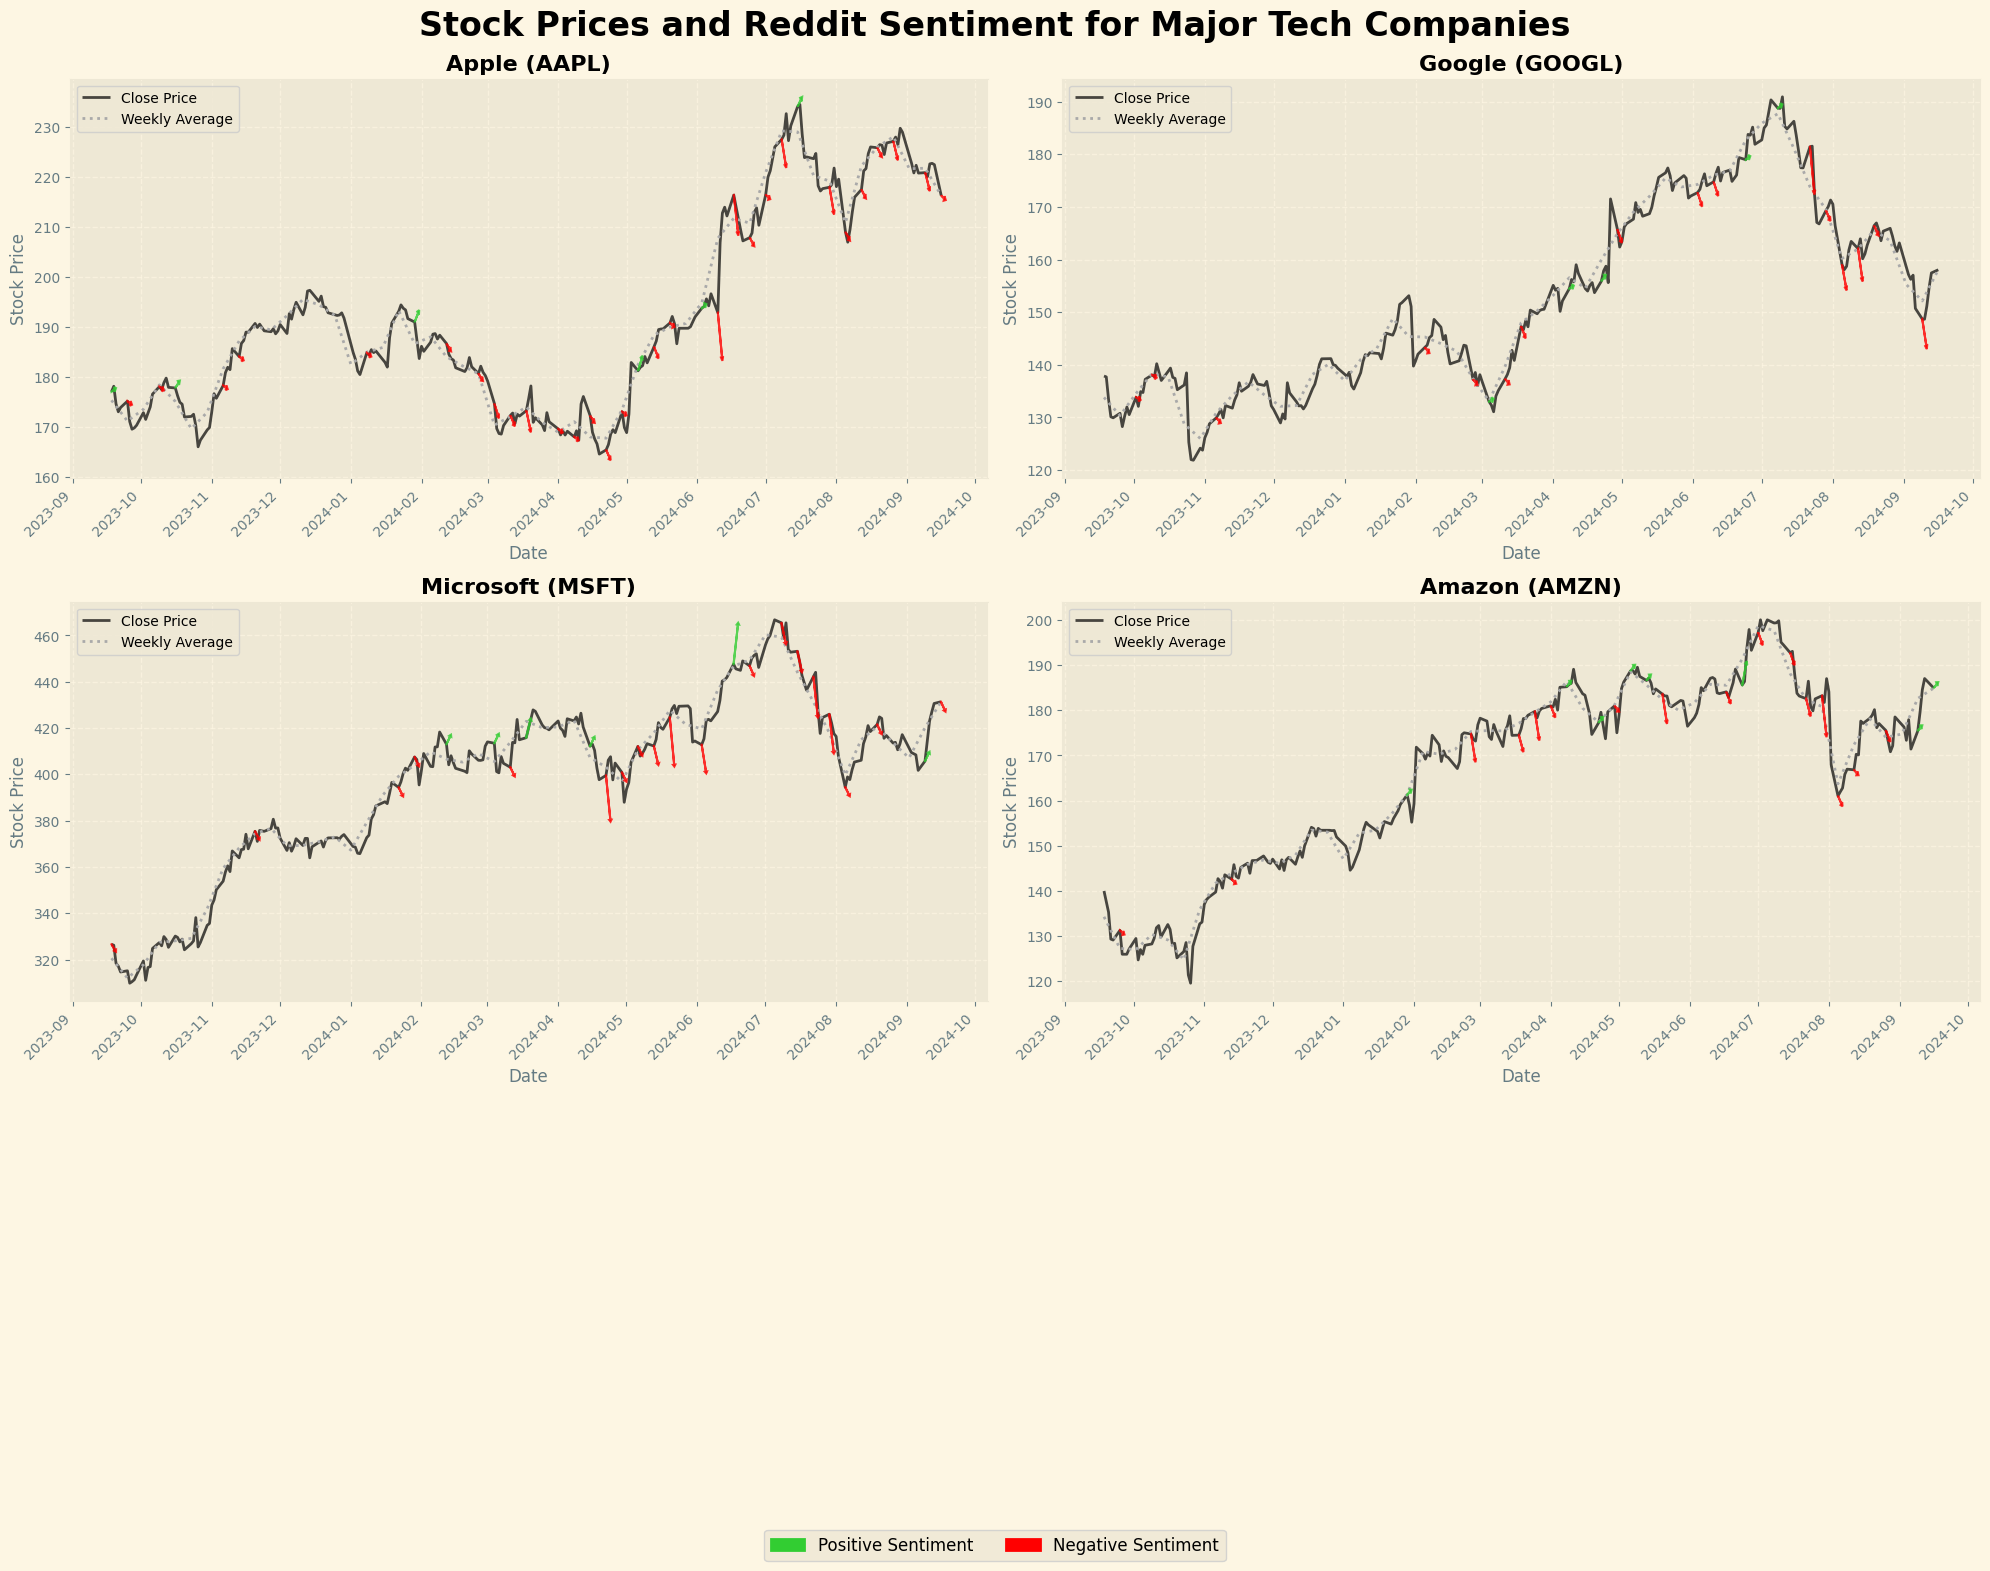

All figures created successfully.


In [74]:
# Generate individual figures
for company, ticker in companies.items():
    
    # Fetch stock data
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    stock_data = create_stock_features(stock_data)
    
    # Filter sentiment data for the current company
    company_df = df[df['company'] == company]
    
    # Group sentiment data by date and sum net sentiment
    sentiment_grouped = company_df.groupby('date_utc')['net_sentiment'].sum().reset_index()
    
    # Merge stock data with aggregated Reddit sentiment data based on dates
    merged_df = pd.merge(stock_data, sentiment_grouped, left_on='Date', right_on='date_utc', how='left')
    
    # Fill NaN values in net_sentiment column with 0
    merged_df['net_sentiment'] = merged_df['net_sentiment'].fillna(0)
    
    # Plot the data
    plot_stock_with_sentiments(merged_df, company, start_date, end_date)

# Generate comprehensive figure
plot_comprehensive_figure(companies, start_date, end_date, df)

print("All figures created successfully.")

## Cell 6: Generate and Display the Comprehensive Figure

In [75]:
# Calculate correlations
for company, ticker in companies.items():
    company_data = df[df['company'] == company]
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    stock_data = create_stock_features(stock_data)
    
    merged_data = pd.merge(company_data, stock_data, left_on='date_utc', right_on='Date', how='inner')
    correlation = merged_data['net_sentiment'].corr(merged_data['Returns'])
    
    print(f"{company} - Correlation between sentiment and returns: {correlation:.4f}")

Apple - Correlation between sentiment and returns: 0.0860
Google - Correlation between sentiment and returns: -0.0424
Microsoft - Correlation between sentiment and returns: 0.2319
Amazon - Correlation between sentiment and returns: 0.3769


## Cell 7: Generate and Display the Correlation Heatmap

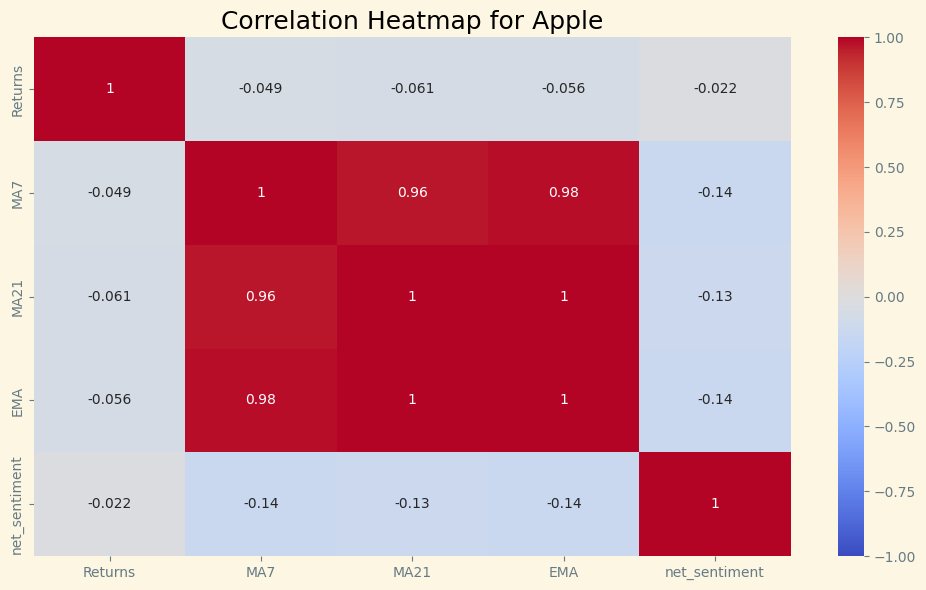

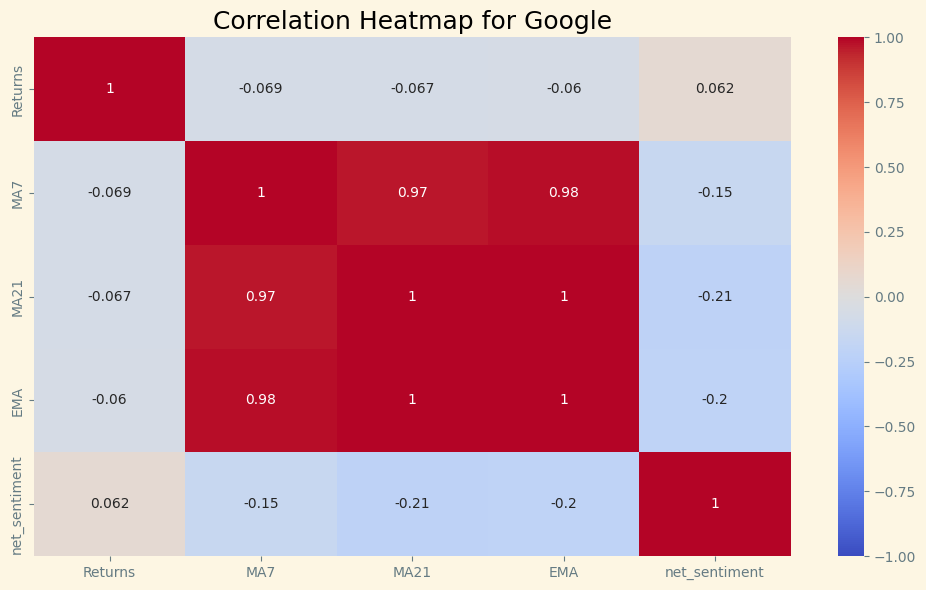

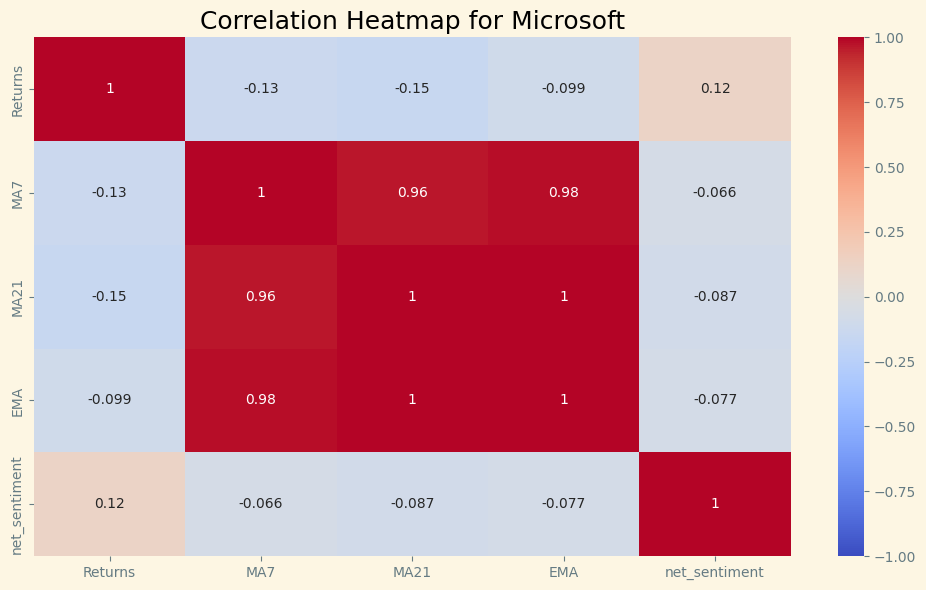

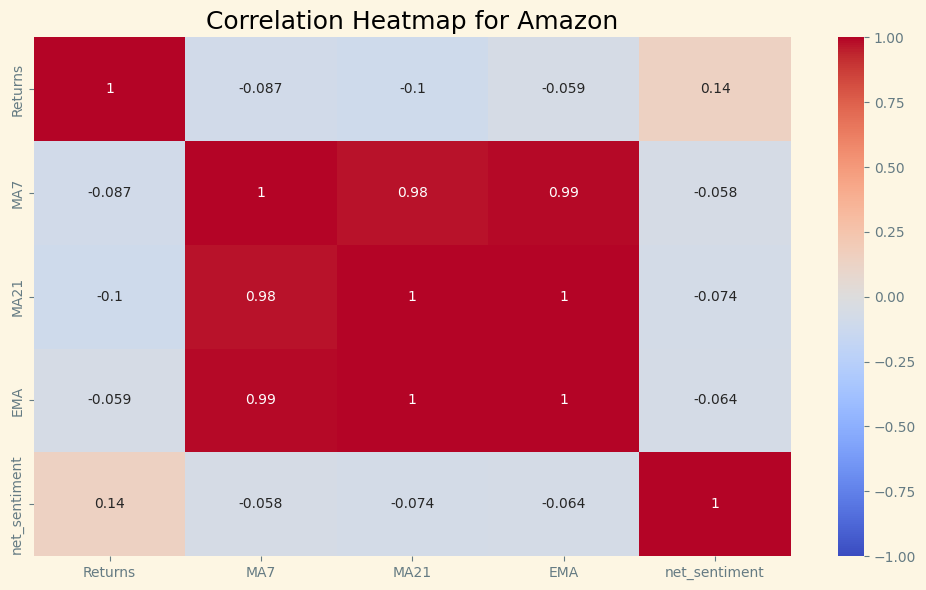

In [76]:
import seaborn as sns

# Create a heatmap showing correlations between sentiment and stock features
def plot_correlation_heatmap(company, merged_df):
    correlation_matrix = merged_df[['Returns', 'MA7', 'MA21', 'EMA', 'net_sentiment']].corr()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for {company}', fontsize=18)
    plt.tight_layout()
    plt.show()

# Generate heatmaps for each company
for company, ticker in companies.items():
    
    # Fetch stock data
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    stock_data = create_stock_features(stock_data)
    
    # Filter sentiment data for the current company
    company_df = df[df['company'] == company]
    
    # Group sentiment data by date and sum net sentiment
    sentiment_grouped = company_df.groupby('date_utc')['net_sentiment'].sum().reset_index()
    
    # Merge stock data with aggregated Reddit sentiment data based on dates
    merged_df = pd.merge(stock_data, sentiment_grouped, left_on='Date', right_on='date_utc', how='left')
    
    # Fill NaN values in net_sentiment column with 0
    merged_df['net_sentiment'] = merged_df['net_sentiment'].fillna(0)
    
    # Plot the heatmap
    plot_correlation_heatmap(company, merged_df)


## Cell 8: Generate and Display a Linear Model

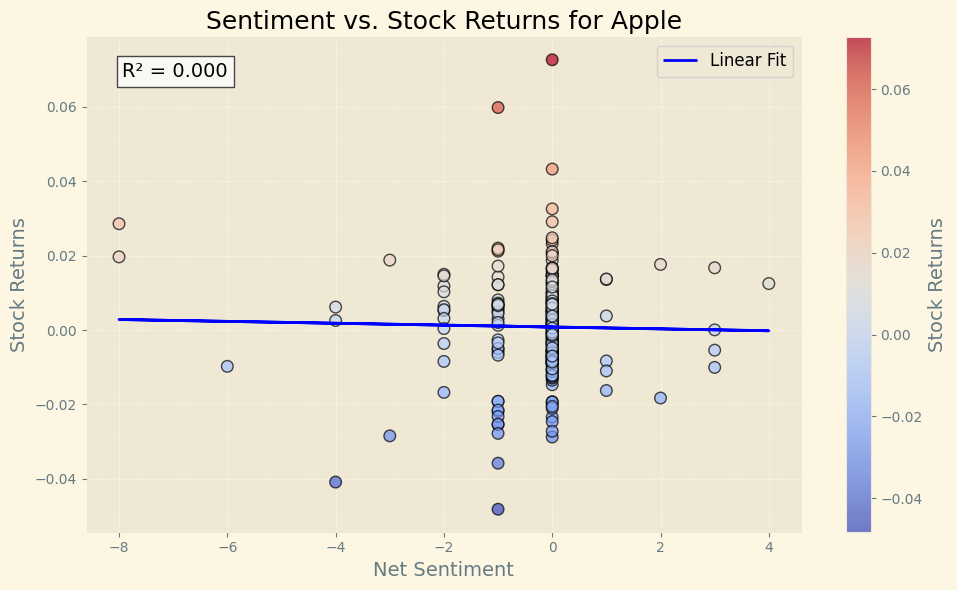

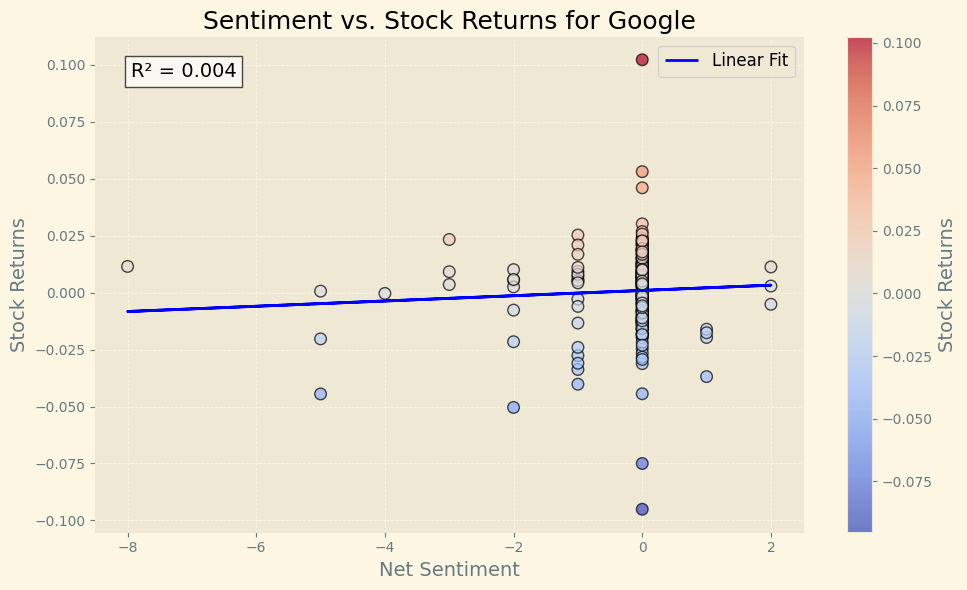

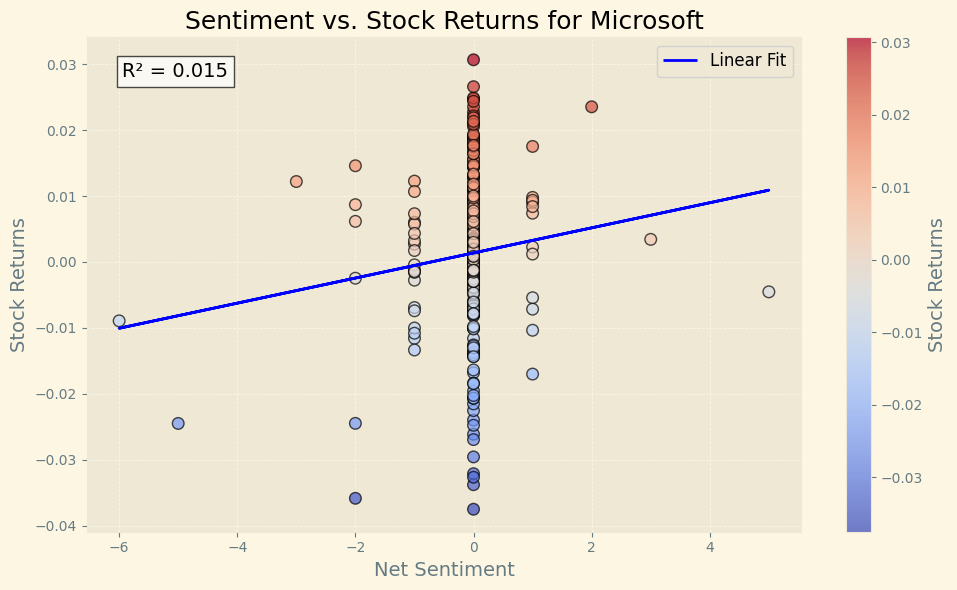

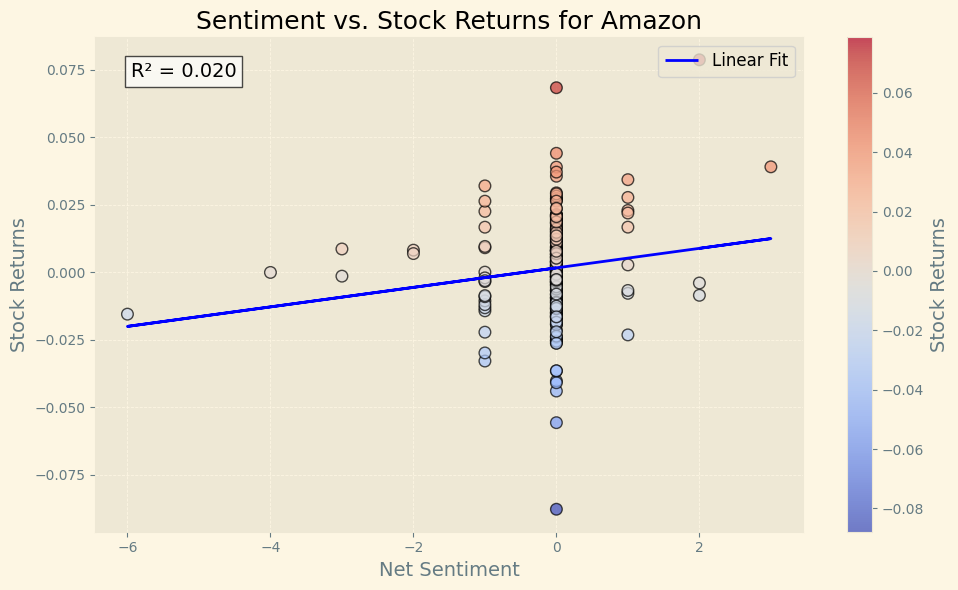

In [77]:
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm

# Create scatter plots showing the relationship between sentiment and returns for each company
def plot_sentiment_vs_returns(merged_df, company):
    # Filter out rows where 'Returns' is NaN or 0 (to avoid log errors and meaningless points)
    filtered_df = merged_df.dropna(subset=['Returns', 'net_sentiment'])
    
    # Set up the figure
    plt.figure(figsize=(10, 6))
    
    # Scatter plot with color gradient
    scatter = plt.scatter(filtered_df['net_sentiment'], filtered_df['Returns'], 
                          alpha=0.7, edgecolor='k', 
                          c=filtered_df['Returns'], cmap='coolwarm', s=70)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Stock Returns', fontsize=14)

    # Add linear regression line
    X = filtered_df['net_sentiment'].values.reshape(-1, 1)  # Reshape for sklearn
    y = filtered_df['Returns'].values
    model = LinearRegression()
    model.fit(X, y)
    predicted = model.predict(X)
    
    plt.plot(filtered_df['net_sentiment'], predicted, color='blue', lw=2, label='Linear Fit')
    
    # Calculate and display the R^2 value (correlation coefficient)
    r_squared = model.score(X, y)
    plt.text(0.05, 0.95, f'R² = {r_squared:.3f}', fontsize=14, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    
    # Highlight and annotate outliers (e.g., where returns deviate significantly from sentiment)
    threshold = 0.15  # Define a threshold for identifying outliers
    outliers = filtered_df[np.abs(filtered_df['Returns'] - predicted) > threshold]
    
    for idx, row in outliers.iterrows():
        plt.annotate(f'{row["Date"]}', 
                     (row['net_sentiment'], row['Returns']), 
                     textcoords="offset points", 
                     xytext=(5,5), ha='center', fontsize=10,
                     arrowprops=dict(facecolor='black', arrowstyle='->', lw=0.5))
    
    # Formatting the plot
    plt.title(f'Sentiment vs. Stock Returns for {company}', fontsize=18)
    plt.xlabel('Net Sentiment', fontsize=14)
    plt.ylabel('Stock Returns', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True, which='major', linestyle='--', linewidth=0.6)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Generate scatter plots for each company
for company, ticker in companies.items():
    
    # Fetch stock data
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    stock_data = create_stock_features(stock_data)
    
    # Filter sentiment data for the current company
    company_df = df[df['company'] == company]
    
    # Group sentiment data by date and sum net sentiment
    sentiment_grouped = company_df.groupby('date_utc')['net_sentiment'].sum().reset_index()
    
    # Merge stock data with aggregated Reddit sentiment data based on dates
    merged_df = pd.merge(stock_data, sentiment_grouped, left_on='Date', right_on='date_utc', how='left')
    
    # Fill NaN values in net_sentiment column with 0
    merged_df['net_sentiment'] = merged_df['net_sentiment'].fillna(0)
    
    # Plot the improved scatter plot
    plot_sentiment_vs_returns(merged_df, company)
